In [1]:
import pandas as pd
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir("/content/drive/MyDrive/Colab Notebooks") 
data = pd.read_csv('data_processed.csv')

In [3]:
data.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,MY
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,1.0,4.0,4.0,3.0,4.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,2.0,5.0,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,4.0,3.0,4.0,2.0,4.0,4.0,4.0,1.0,2.0,2.0,3.0,1.0,4.0,4.0,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,GB
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,1.0,5.0,5.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,5.0,3.0,5.0,1.0,5.0,1.0,3.0,1.0,5.0,1.0,5.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,3.0,5.0,5.0,KE


In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [5]:
np_data = data.to_numpy()#enc.fit(data['EXT1'].tolist())
#targets = enc.transform(data['EXT1'].tolist()).toarray()

In [6]:
labels = np_data[:,0].reshape(-1,1)

In [7]:
enc.fit(labels)
targets = enc.transform(labels).toarray()

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
x_train = np_data[:500000,1:50]

In [10]:
y_train = targets[:500000,:]

In [11]:
x_test = np_data[500000:,1:50]
y_test = targets[500000:,:]

In [12]:
clf = RandomForestClassifier(random_state=4651)

In [13]:
targets.shape

(873173, 5)

In [14]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=4651,
                       verbose=0, warm_start=False)

In [15]:
y_pred = clf.predict(x_test)

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':


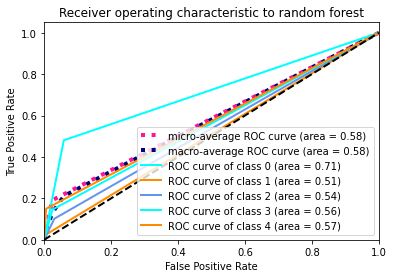

In [18]:
from scipy import interp
from itertools import cycle
lw = 2

n_classes = 5
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to random forest')
plt.legend(loc="lower right")
plt.show()



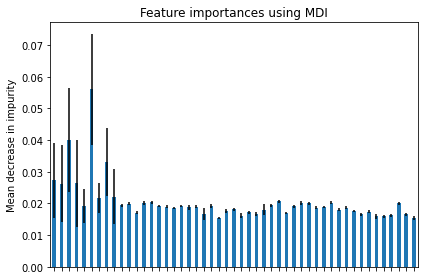

In [22]:
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.setp(ax.get_xticklabels(), visible=False)
fig.tight_layout()